<a href="https://colab.research.google.com/github/vubanc/MovieGenreIdentifier_NLP/blob/main/EDA%20%26%20Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing Libraries and Datasets**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import spacy

import random

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
pd.set_option('display.max_rows', None)

#Importing three datasets containing information on movies
%cd /content/drive/MyDrive/Work/Personal Projects/MovieGenreIdentifier_NLP
df1 = pd.read_csv("Highest Holywood Grossing Movies.csv")
df2 = pd.read_csv("Netflix TV Shows and Movies.csv")
df3 = pd.read_csv("IMDB Movies Dataset.csv")

/content/drive/MyDrive/Work/Personal Projects/MovieGenreIdentifier_NLP


In [5]:
print(df1.shape)
df1.head(2)

(918, 11)


,Unnamed: 0,Title,Movie Info,Distributor,Release Date,Domestic Sales (in $),International Sales (in $),World Sales (in $),Genre,Movie Runtime,License
0,0,Star Wars: Episode VII - The Force Awakens (2015),"As a new threat to the galaxy rises, Rey, a de...",Walt Disney Studios Motion Pictures,"December 16, 2015",936662225,1132859475,2069521700,"['Action', 'Adventure', 'Sci-Fi']",2 hr 18 min,PG-13
1,1,Avengers: Endgame (2019),After the devastating events of Avengers: Infi...,Walt Disney Studios Motion Pictures,"April 24, 2019",858373000,1939128328,2797501328,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",3 hr 1 min,PG-13


In [6]:
print(df2.shape)
df2.head(2)

(5850, 15)


,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179


In [7]:
print(df3.shape)
df3.head(2)

(1000, 16)


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"


### **Combined Dataset Preparation**

In [8]:
#Preprocessing the first dataset

for row in range(len(df1)):
    df1.loc[row, "Movie Genre"] = re.sub(r"[^\w\s]", "", df1.loc[row, "Genre"]) #Using regex to drop symbols & numbers
    df1.loc[row, "Movie Genre"] = df1.loc[row, "Movie Genre"].lower()
    #The following regular expression only keeps movies from the most common genres
    df1.loc[row, "Movie Genre"] = re.sub(r"\b(?!(action|adventure|drama|comedy|romance|thriller|horror)\b)\w+\b", "", df1.loc[row, "Movie Genre"])
    df1.loc[row, "Movie Genre"] = re.sub(r"[\s]+$", "", df1.loc[row, "Movie Genre"]) #Removing spaces at the end
    df1.loc[row, "Movie Genre"] = re.sub(r"^[\s]+", "", df1.loc[row, "Movie Genre"]) #Removing spaces at the beginning
    df1.loc[row, "Movie Genre"] = re.sub(r"\b[\s]{2,}\b", " ", df1.loc[row, "Movie Genre"]) #Removing spaces in the middle
    df1.loc[row, "Movie Genre"] = re.sub(r"\b(action|adventure)\b", "action/adventure", df1.loc[row, "Movie Genre"]) #Merging
    df1.loc[row, "Movie Genre"] = re.sub(r"\b(thriller|horror)\b", "thriller/horror", df1.loc[row, "Movie Genre"]) #Merging

df1 = df1[df1["Movie Genre"]!=""] #Removing movies whose genres were replaced by "" with the above regular expressions
df1.reset_index(inplace=True)
df1["Movie Genre"] = df1["Movie Genre"].str.split(" ")
df1 = df1[["Title", "Movie Info", "Movie Genre"]]
df1.columns = ["Movie Title", "Movie Description", "Movie Genre"]

unique_genres = ["Action/Adventure", "Romance", "Drama", "Comedy", "Thriller/Horror"]
print(unique_genres)

for genre in unique_genres:
    for row in range(len(df1)):
        df1.loc[row, genre] = (genre.lower() in df1.loc[row, "Movie Genre"])
    df1[genre] = df1[genre].astype(int)


print(df1.shape)
df1.head()

['Action/Adventure', 'Romance', 'Drama', 'Comedy', 'Thriller/Horror']
(918, 8)


,Movie Title,Movie Description,Movie Genre,Action/Adventure,Romance,Drama,Comedy,Thriller/Horror
0,Star Wars: Episode VII - The Force Awakens (2015),"As a new threat to the galaxy rises, Rey, a de...","[action/adventure, action/adventure]",1,0,0,0,0
1,Avengers: Endgame (2019),After the devastating events of Avengers: Infi...,"[action/adventure, action/adventure, drama]",1,0,1,0,0
2,Avatar (2009),A paraplegic Marine dispatched to the moon Pan...,"[action/adventure, action/adventure]",1,0,0,0,0
3,Black Panther (2018),"T'Challa, heir to the hidden but advanced king...","[action/adventure, action/adventure]",1,0,0,0,0
4,Avengers: Infinity War (2018),The Avengers and their allies must be willing ...,"[action/adventure, action/adventure]",1,0,0,0,0


In [9]:
#Preprocessing the second dataset

for row in range(len(df2)):
    df2.loc[row, "Movie Genre"] = re.sub(r"[^\w\s]", "", df2.loc[row, "genres"]) #Using regex to drop symbols & numbers
    df2.loc[row, "Movie Genre"] = df2.loc[row, "Movie Genre"].lower()
    #The following regular expression only keeps movies from the most common genres
    df2.loc[row, "Movie Genre"] = re.sub(r"\b(?!(action|adventure|drama|comedy|romance|thriller|horror)\b)\w+\b", "", df2.loc[row, "Movie Genre"])
    df2.loc[row, "Movie Genre"] = re.sub(r"[\s]+$", "", df2.loc[row, "Movie Genre"]) #Removing spaces at the end
    df2.loc[row, "Movie Genre"] = re.sub(r"^[\s]+", "", df2.loc[row, "Movie Genre"]) #Removing spaces at the beginning
    df2.loc[row, "Movie Genre"] = re.sub(r"\b[\s]{2,}\b", " ", df2.loc[row, "Movie Genre"]) #Removing spaces in the middle
    df2.loc[row, "Movie Genre"] = re.sub(r"\b(action|adventure)\b", "action/adventure", df2.loc[row, "Movie Genre"]) #Merging
    df2.loc[row, "Movie Genre"] = re.sub(r"\b(thriller|horror)\b", "thriller/horror", df2.loc[row, "Movie Genre"]) #Merging

df2 = df2[df2["type"]=="MOVIE"]
df2 = df2[df2["Movie Genre"]!=""] #Removing movies whose genres were replaced by "" with the above regular expressions
df2.reset_index(inplace=True)
df2["Movie Genre"] = df2["Movie Genre"].str.split(" ")
df2 = df2[["title", "description", "Movie Genre"]]
df2.columns = ["Movie Title", "Movie Description", "Movie Genre"]

unique_genres = ["Action/Adventure", "Romance", "Drama", "Comedy", "Thriller/Horror"]
print(unique_genres)

for genre in unique_genres:
    for row in range(len(df2)):
        df2.loc[row, genre] = (genre.lower() in df2.loc[row, "Movie Genre"])
    df2[genre] = df2[genre].astype(int)

df2 = df2[df2["Movie Title"].isin(list(df2["Movie Title"].unique()))]

print(df2.shape)
df2.head()

['Action/Adventure', 'Romance', 'Drama', 'Comedy', 'Thriller/Horror']
(3194, 8)


,Movie Title,Movie Description,Movie Genre,Action/Adventure,Romance,Drama,Comedy,Thriller/Horror
0,Taxi Driver,A mentally unstable Vietnam War veteran works ...,[drama],0,0,1,0,0
1,Deliverance,Intent on seeing the Cahulawassee River before...,"[drama, action/adventure, thriller/horror]",1,0,1,0,1
2,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui...","[action/adventure, comedy]",1,0,0,1,0
3,The Dirty Dozen,12 American military prisoners in World War II...,[action/adventure],1,0,0,0,0
4,Life of Brian,"Brian Cohen is an average young Jewish man, bu...",[comedy],0,0,0,1,0


In [10]:
#Preprocessing the third dataset

for row in range(len(df3)):
    df3.loc[row, "Movie Genre"] = re.sub(r"[^\w\s]", "", df3.loc[row, "Genre"]) #Using regex to drop symbols & numbers
    df3.loc[row, "Movie Genre"] = df3.loc[row, "Movie Genre"].lower()
    #The following regular expression only keeps movies from the most common genres
    df3.loc[row, "Movie Genre"] = re.sub(r"\b(?!(action|adventure|comedy|romance|thriller|horror)\b)\w+\b", "", df3.loc[row, "Movie Genre"])
    df3.loc[row, "Movie Genre"] = re.sub(r"[\s]+$", "", df3.loc[row, "Movie Genre"]) #Removing spaces at the end
    df3.loc[row, "Movie Genre"] = re.sub(r"^[\s]+", "", df3.loc[row, "Movie Genre"]) #Removing spaces at the beginning
    df3.loc[row, "Movie Genre"] = re.sub(r"\b[\s]{2,}\b", " ", df3.loc[row, "Movie Genre"]) #Removing spaces in the middle
    df3.loc[row, "Movie Genre"] = re.sub(r"\b(action|adventure)\b", "action/adventure", df3.loc[row, "Movie Genre"]) #Merging
    df3.loc[row, "Movie Genre"] = re.sub(r"\b(thriller|horror)\b", "thriller/horror", df3.loc[row, "Movie Genre"]) #Merging

df3 = df3[df3["Movie Genre"]!=""] #Removing movies whose genres were replaced by "" with the above regular expressions
df3.reset_index(inplace=True)
df3["Movie Genre"] = df3["Movie Genre"].str.split(" ")
df3 = df3[["Series_Title", "Overview", "Movie Genre"]]
df3.columns = ["Movie Title", "Movie Description", "Movie Genre"]


unique_genres = ["Action/Adventure", "Romance", "Drama", "Comedy", "Thriller/Horror"]
print(unique_genres)

for genre in unique_genres:
    for row in range(len(df3)):
        df3.loc[row, genre] = (genre.lower() in df3.loc[row, "Movie Genre"])
    df3[genre] = df3[genre].astype(int)

df3 = df3[df3["Movie Title"].isin(list(df3["Movie Title"].unique()))]

print(df3.shape)
df3.head()

<ipython-input-10-a75c4cf086a5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Movie Genre"] = df3["Movie Genre"].str.split(" ")


['Action/Adventure', 'Romance', 'Drama', 'Comedy', 'Thriller/Horror']
(657, 8)


,Movie Title,Movie Description,Movie Genre,Action/Adventure,Romance,Drama,Comedy,Thriller/Horror
0,The Dark Knight,When the menace known as the Joker wreaks havo...,[action/adventure],1,0,0,0,0
1,The Lord of the Rings: The Return of the King,Gandalf and Aragorn lead the World of Men agai...,"[action/adventure, action/adventure]",1,0,0,0,0
2,Inception,A thief who steals corporate secrets through t...,"[action/adventure, action/adventure]",1,0,0,0,0
3,The Lord of the Rings: The Fellowship of the Ring,A meek Hobbit from the Shire and eight compani...,"[action/adventure, action/adventure]",1,0,0,0,0
4,Forrest Gump,"The presidencies of Kennedy and Johnson, the e...",[romance],0,1,0,0,0


In [11]:
#Concatenating the three datasets
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)
df.dropna(axis=0, subset=["Movie Description"], inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head()

(4766, 8)


,Movie Title,Movie Description,Movie Genre,Action/Adventure,Romance,Drama,Comedy,Thriller/Horror
0,Star Wars: Episode VII - The Force Awakens (2015),"As a new threat to the galaxy rises, Rey, a de...","[action/adventure, action/adventure]",1,0,0,0,0
1,Avengers: Endgame (2019),After the devastating events of Avengers: Infi...,"[action/adventure, action/adventure, drama]",1,0,1,0,0
2,Avatar (2009),A paraplegic Marine dispatched to the moon Pan...,"[action/adventure, action/adventure]",1,0,0,0,0
3,Black Panther (2018),"T'Challa, heir to the hidden but advanced king...","[action/adventure, action/adventure]",1,0,0,0,0
4,Avengers: Infinity War (2018),The Avengers and their allies must be willing ...,"[action/adventure, action/adventure]",1,0,0,0,0


,Movie Genre,Proportion
0,Action/Adventure,0.335711
1,Romance,0.202476
2,Drama,0.456148
3,Comedy,0.462023
4,Thriller/Horror,0.273395


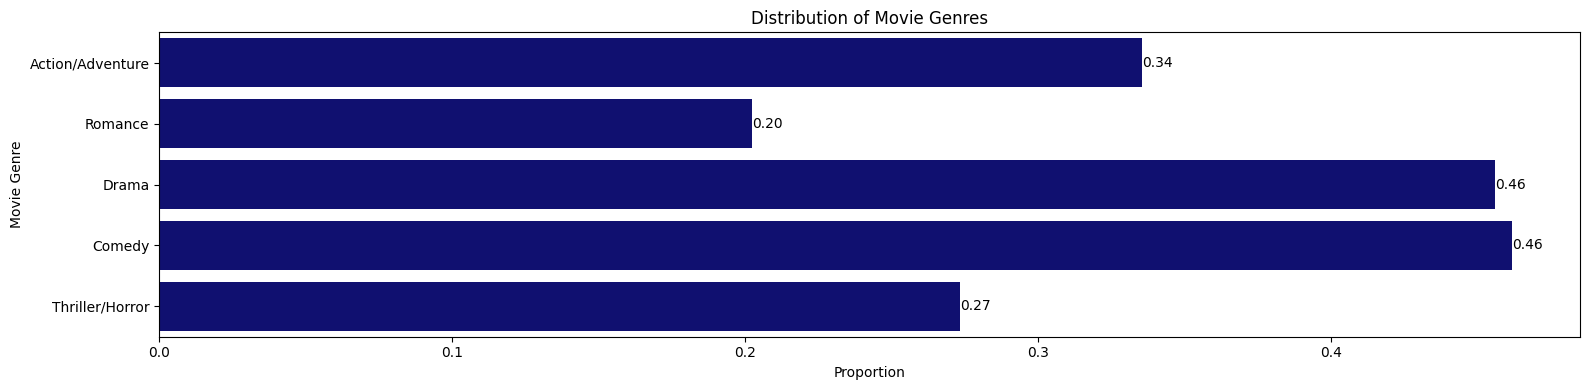

In [12]:
#Displaying the distribution of the genres

data_distribution = pd.DataFrame(df[["Action/Adventure", "Romance", "Drama", "Comedy", "Thriller/Horror"]].mean())
data_distribution.reset_index(inplace=True)
data_distribution.columns = ["Movie Genre", "Proportion"]

fig, axs = plt.subplots(1,1, figsize=(16,4))
sns.barplot(data=data_distribution, y="Movie Genre", x = "Proportion", color="navy", ax=axs)
axs.bar_label(axs.containers[0], fmt="%.2f")
axs.set_title("Distribution of Movie Genres")

plt.tight_layout()
data_distribution

### **Tokenization and Document-Term Matrix Preparation**

In [13]:
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4') #A open multilingual wordnet that has definitions of words and their relationships
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [14]:
stop_words =  stopwords.words('english')
nlp = spacy.load("en_core_web_sm")

def CleanText(text, remove_stop_words = False, lemmatize_words = False):
    doc = nlp(text)
    clean_text = " ".join([str(token) for token in doc if token.pos_ != "PROPN"]) #Removing proper nouns

    clean_text = re.sub("(’s)?('s)?", "", clean_text) #Removing apostrophe s
    clean_text = re.sub("(s’)?(s')", "s", clean_text) #Removing apostrophe s
    clean_text = re.sub("(https://)?(www.)?.+(\.com).+", "", clean_text) #Removing links
    clean_text = re.sub("[^a-zA-Z0-9\s]", " ", clean_text) #Removing punctuation
    clean_text = "".join([c for c in clean_text if c not in punctuation])
    clean_text = re.sub("[0-9]\.?[0-9]?", "", clean_text) #Removing numbers
    clean_text = re.sub(r"\b\w\b",  "", clean_text) #Removing isolated alphabets (\b works better than ^ and $)
    clean_text = re.sub("[\s]+", " ", clean_text) #Removing multiple spaces
    clean_text = re.sub("^[\s]","", clean_text) #Removing spaces at the beginning
    clean_text = re.sub("[\s]$","", clean_text) #Removing spaces at the end
    clean_text = clean_text.lower() #Converting to lowercase


    if remove_stop_words==True:
        clean_text = clean_text.split(" ")
        clean_text = [word for word in clean_text if word not in stop_words]
        clean_text = " ".join(clean_text)

    if lemmatize_words==True:
        clean_text = clean_text.split(" ")
        lemmatizer = WordNetLemmatizer()
        clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
        clean_text = " ".join(clean_text)
    return clean_text

In [15]:
for row in range(len(df)):
    df.loc[row,"Movie Description"] = CleanText(df.loc[row,"Movie Description"], True, True)

In [16]:
cv = CountVectorizer(stop_words = "english")
df_cv = cv.fit_transform(df["Movie Description"])
df_dtm = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names_out())
#df_dtm["Movie Genre"] = df["Movie Genre"]
df_dtm = pd.concat([df_dtm, df[["Action/Adventure", "Romance", "Drama", "Comedy", "Thriller/Horror"]]], axis=1)
df_dtm.reset_index(inplace=True, drop=True)

In [17]:
print(df_dtm.shape)
df_dtm.head()

(4766, 10207)


,aaliya,aasi,aback,abandon,abandoned,abandoning,abdomen,abduct,abducted,abduction,...,zone,zoo,zookeeper,zoological,zor,Action/Adventure,Romance,Drama,Comedy,Thriller/Horror
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### **Exploratory Data Analysis**

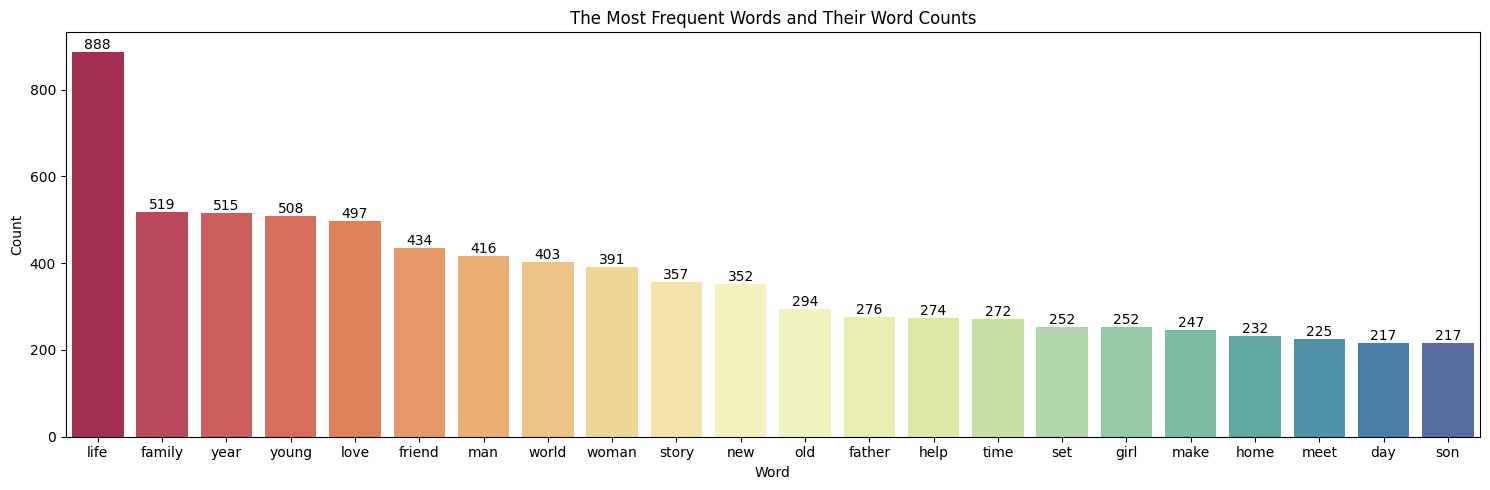

In [18]:
#Finding the most frequent words in movie descriptions
df_word_count = pd.DataFrame(df_dtm.iloc[:,0:-5].sum(axis=0))
df_word_count.reset_index(inplace=True)
df_word_count.columns = ["Word", "Count"]
df_word_count = df_word_count.sort_values("Count", ascending=False)
df_word_count.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(1,1,figsize=(15,5))
sns.barplot(data=df_word_count.loc[0:21,:], x="Word", y="Count", palette="Spectral", ax=axs)
axs.set_title("The Most Frequent Words and Their Word Counts")
axs.bar_label(axs.containers[0])

plt.tight_layout()

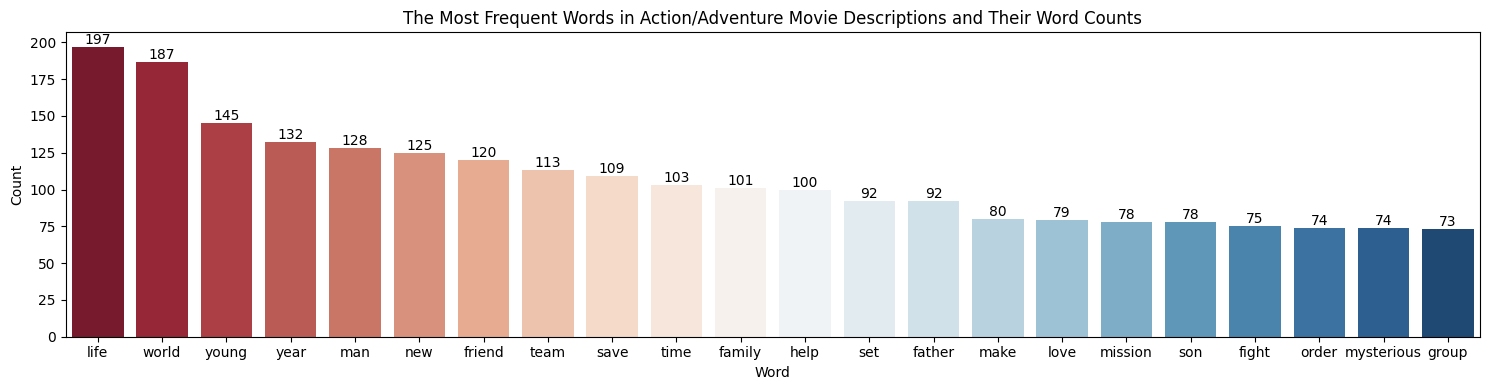

In [19]:
#Finding the most frequent words in action/adventure movie descriptions
df_action = df_dtm[df_dtm["Action/Adventure"]==1]

df_word_count = pd.DataFrame(df_action.iloc[:,0:-5].sum(axis=0))
df_word_count.reset_index(inplace=True)
df_word_count.columns = ["Word", "Count"]
df_word_count = df_word_count.sort_values("Count", ascending=False)
df_word_count.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(1,1,figsize=(15,4))
sns.barplot(data=df_word_count.loc[0:21,:], x="Word", y="Count", palette="RdBu", ax=axs)
axs.set_title("The Most Frequent Words in Action/Adventure Movie Descriptions and Their Word Counts")
axs.bar_label(axs.containers[0])

plt.tight_layout()

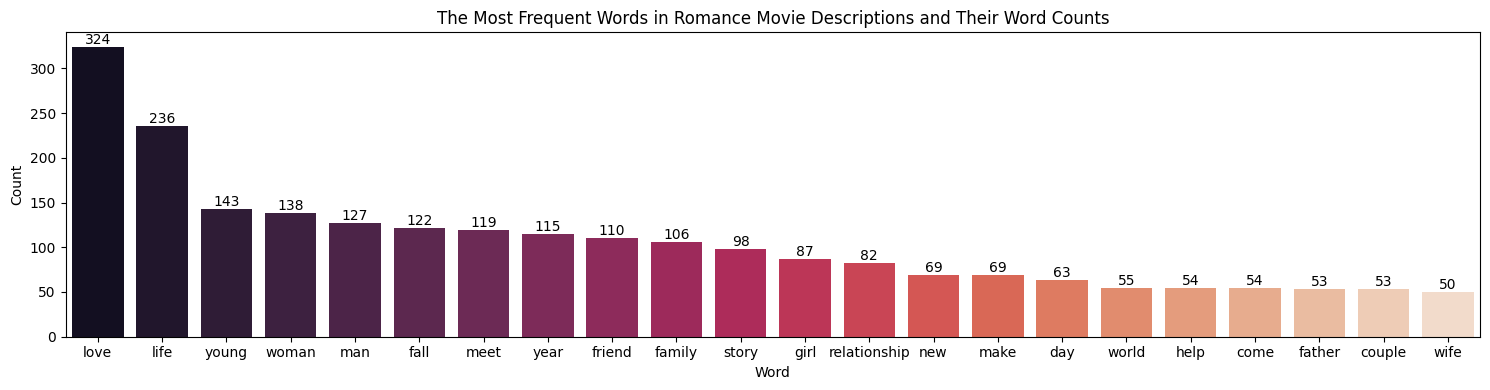

In [20]:
#Finding the most frequent words in romance movie descriptions
df_romance = df_dtm[df_dtm["Romance"]==1]

df_word_count = pd.DataFrame(df_romance.iloc[:,0:-5].sum(axis=0))
df_word_count.reset_index(inplace=True)
df_word_count.columns = ["Word", "Count"]
df_word_count = df_word_count.sort_values("Count", ascending=False)
df_word_count.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(1,1,figsize=(15,4))
sns.barplot(data=df_word_count.loc[0:21,:], x="Word", y="Count", palette="rocket", ax=axs)
axs.set_title("The Most Frequent Words in Romance Movie Descriptions and Their Word Counts")
axs.bar_label(axs.containers[0])

plt.tight_layout()

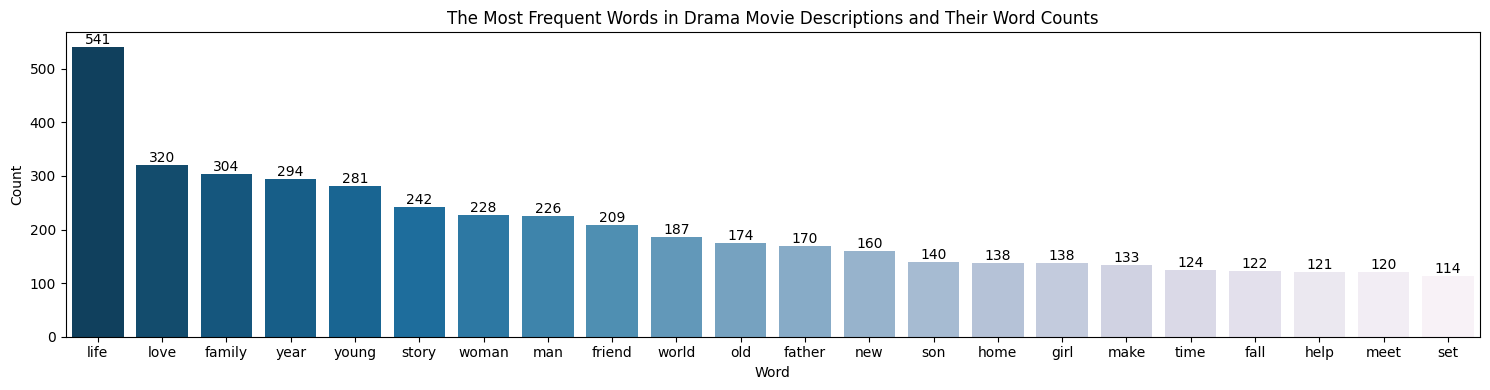

In [21]:
#Finding the most frequent words in drama movie descriptions
df_drama = df_dtm[df_dtm["Drama"]==1]

df_word_count = pd.DataFrame(df_drama.iloc[:,0:-5].sum(axis=0))
df_word_count.reset_index(inplace=True)
df_word_count.columns = ["Word", "Count"]
df_word_count = df_word_count.sort_values("Count", ascending=False)
df_word_count.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(1,1,figsize=(15,4))
sns.barplot(data=df_word_count.loc[0:21,:], x="Word", y="Count", palette="PuBu_r", ax=axs)
axs.set_title("The Most Frequent Words in Drama Movie Descriptions and Their Word Counts")
axs.bar_label(axs.containers[0])

plt.tight_layout()

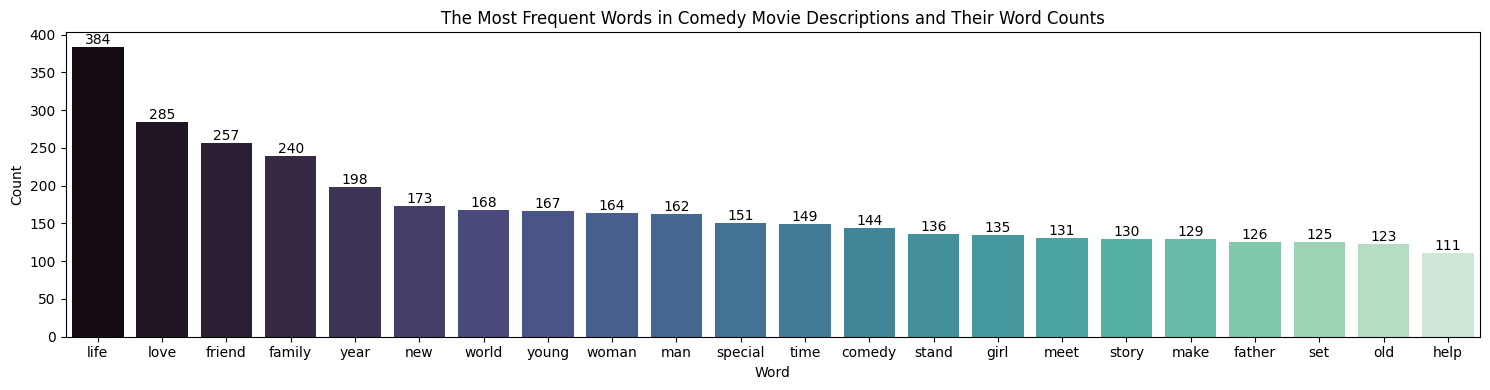

In [22]:
#Finding the most frequent words in comedy movie descriptions
df_comedy = df_dtm.loc[df_dtm["Comedy"]==1, :]

df_word_count = pd.DataFrame(df_comedy.iloc[:,0:-5].sum(axis=0))
df_word_count.reset_index(inplace=True)
df_word_count.columns = ["Word", "Count"]
df_word_count = df_word_count.sort_values("Count", ascending=False)
df_word_count.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(1,1,figsize=(15,4))
sns.barplot(data=df_word_count.loc[0:21,:], x="Word", y="Count", palette="mako", ax=axs)
axs.set_title("The Most Frequent Words in Comedy Movie Descriptions and Their Word Counts")
axs.bar_label(axs.containers[0])

plt.tight_layout()

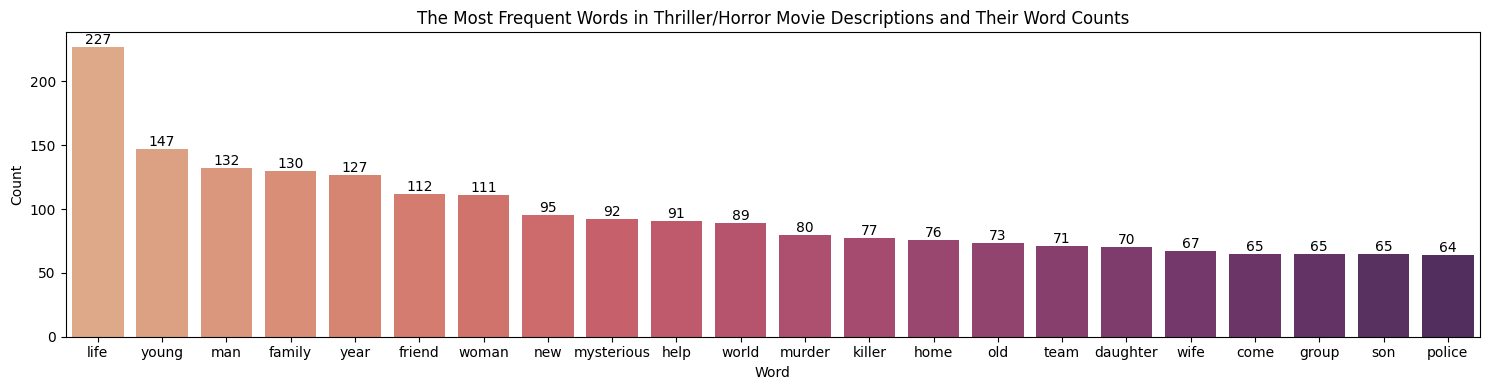

In [23]:
#Finding the most frequent word in thriller/horror movies
df_thriller = df_dtm.loc[df_dtm["Thriller/Horror"]==1, :]

df_word_count = pd.DataFrame(df_thriller.iloc[:,0:-5].sum(axis=0))
df_word_count.reset_index(inplace=True)
df_word_count.columns = ["Word", "Count"]
df_word_count = df_word_count.sort_values("Count", ascending=False)
df_word_count.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(1,1,figsize=(15,4))
sns.barplot(data=df_word_count.loc[0:21,:], x="Word", y="Count", palette="flare", ax=axs)
axs.set_title("The Most Frequent Words in Thriller/Horror Movie Descriptions and Their Word Counts")
axs.bar_label(axs.containers[0])

plt.tight_layout()

count    10202.000000
mean         7.264752
std         23.683131
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        888.000000
Name: Count, dtype: float64

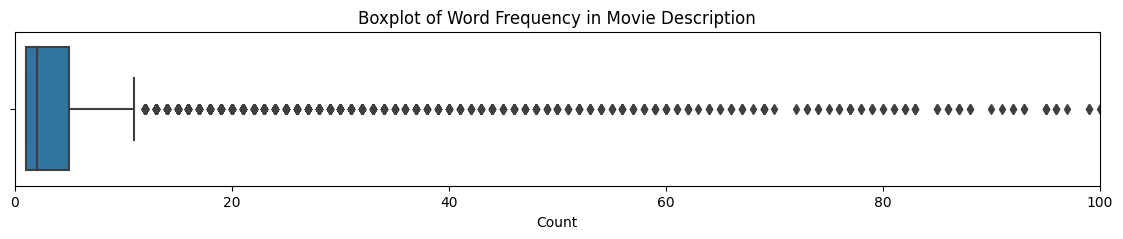

In [24]:
#How frequently do the words come up in the descriptions?
df_word_count = pd.DataFrame(df_dtm.iloc[:,0:-5].sum(axis=0))
df_word_count.reset_index(inplace=True)
df_word_count.columns = ["Word", "Count"]

fig, axs = plt.subplots(1,1,figsize=(14,2))
sns.boxplot(data=df_word_count, x="Count", ax=axs)
axs.set_title("Boxplot of Word Frequency in Movie Description")
axs.set_xlim(left=0,right=100)

df_word_count["Count"].describe()

count    4766.000000
mean       17.007134
std         9.296963
min         1.000000
25%        12.000000
50%        14.000000
75%        19.000000
max       100.000000
Name: Length, dtype: float64

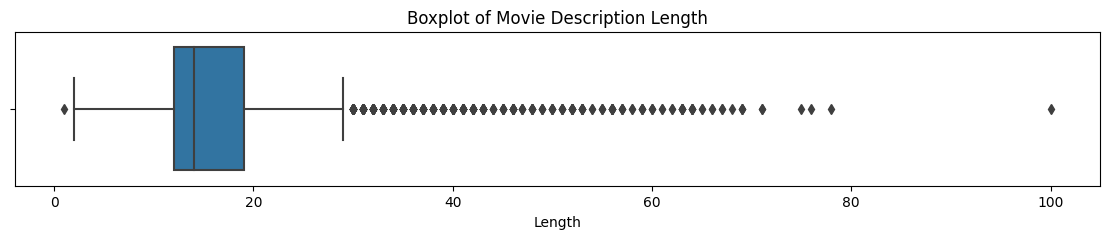

In [25]:
#How long are the movie descriptions?
df_des_length = pd.DataFrame(df_dtm.iloc[:,0:-1].sum(axis=1))
df_des_length.columns = ["Length"]
fig, axs = plt.subplots(1,1,figsize=(14,2))
sns.boxplot(data=df_des_length, x="Length", ax=axs)
axs.set_title("Boxplot of Movie Description Length")

df_des_length["Length"].describe()

In [26]:
#Removing observations with description lengths below 10 words (25 percentile length)
df_dtm = df_dtm[df_des_length["Length"]>12] #25th Percentile
df_dtm.reset_index(inplace=True, drop=True)
print(f"Total Movies: {len(df_dtm)}")

Total Movies: 3251


,Movie Genre,Proportion
0,Action/Adventure,0.334666
1,Romance,0.232236
2,Drama,0.516764
3,Comedy,0.466626
4,Thriller/Horror,0.276838


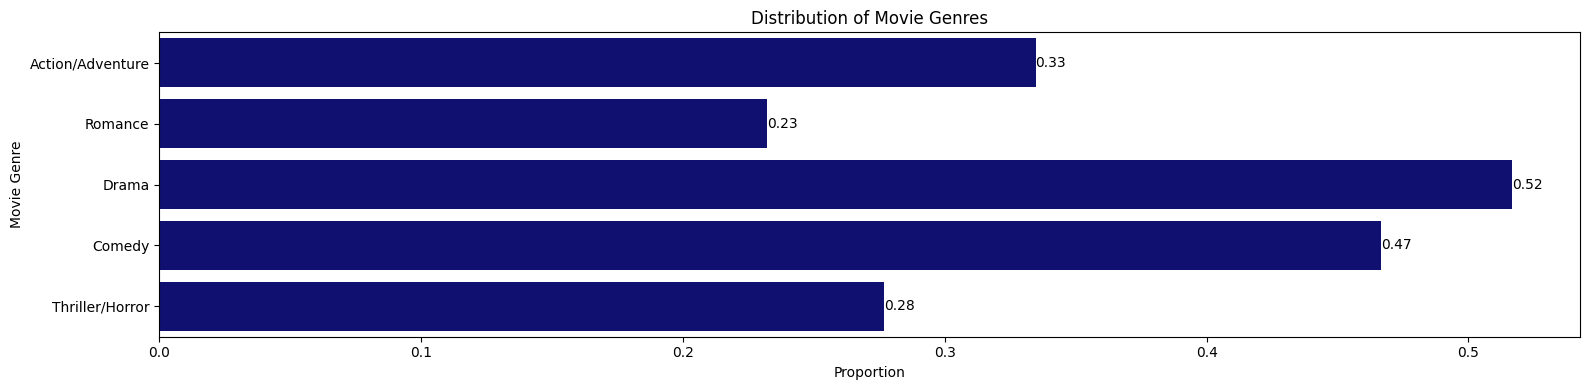

In [27]:
data_distribution = pd.DataFrame(df_dtm[["Action/Adventure", "Romance", "Drama", "Comedy", "Thriller/Horror"]].mean())
data_distribution.reset_index(inplace=True)
data_distribution.columns = ["Movie Genre", "Proportion"]

fig, axs = plt.subplots(1,1, figsize=(16,4))
sns.barplot(data=data_distribution, y="Movie Genre", x = "Proportion", color="navy", ax=axs)
axs.bar_label(axs.containers[0], fmt="%.2f")
axs.set_title("Distribution of Movie Genres")

plt.tight_layout()
data_distribution

### **LSTM Input Preparation**

In [28]:
df_input = pd.DataFrame(cv.inverse_transform(df_dtm.iloc[:,0:-5]))
df_input = pd.concat([df_input,df_dtm[["Action/Adventure", "Romance", "Drama", "Comedy", "Thriller/Horror"]]], axis=1)
df_input.fillna(0, inplace=True)
df_input = df_input.sample(frac=1, random_state=32)
df_input.reset_index(inplace=True, drop=True)
df_input.head(6)

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,Action/Adventure,Romance,Drama,Comedy,Thriller/Horror
0,come,deepest,hungry,kindhearted,lamp,magic,make,power,street,true,...,0,0,0,0,0,1,0,0,1,0
1,access,battle,early,educational,improve,indonesian,nobility,norm,order,patriarchal,...,0,0,0,0,0,0,0,1,0,0
2,alter,bloody,brings,comedian,crime,disregarded,downward,ego,embarks,face,...,0,0,0,0,0,0,0,0,0,1
3,anniversary,appears,bed,clueless,daughter,family,generation,longer,parent,sleep,...,0,0,0,0,0,0,1,1,1,0
4,ago,betrayed,bring,final,force,given,justice,man,mission,opportunity,...,0,0,0,0,0,1,0,0,0,0
5,biggest,boxed,comedian,crowd,hangover,recasting,regret,roaring,sex,stand,...,0,0,0,0,0,0,0,0,1,0


In [29]:
vocabulary = list(df_dtm.iloc[:,0:-5].columns)
len(vocabulary)

10202

In [30]:
#Creating a numpy array of input features
features = []

for i in range(len(df_input)):
  temp_list=[]
  for j in range(0,81):
    word = df_input.iloc[i,j]
    if word!=0:
      word_index = vocabulary.index(word)
      temp_list.append(word_index)
    else:
      temp_list.insert(0,0)
  features.append(temp_list)

features = np.array(features)
features.shape

(3251, 81)

In [31]:
#Creating binary label arrays for each genre
action_labels = np.array(df_input["Action/Adventure"].values.tolist())
romance_labels = np.array(df_input["Romance"].values.tolist())
drama_labels = np.array(df_input["Drama"].values.tolist())
comedy_labels = np.array(df_input["Comedy"].values.tolist())
thriller_labels = np.array(df_input["Thriller/Horror"].values.tolist())

In [38]:
df_input = pd.DataFrame(features)
df_input["action_labels"] = action_labels
df_input["romance_labels"] = romance_labels
df_input["drama_labels"] = drama_labels
df_input["comedy_labels"] = comedy_labels
df_input["thriller_labels"] = thriller_labels
df_input.head()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,action_labels,romance_labels,drama_labels,comedy_labels,thriller_labels
0,0,0,0,0,0,0,0,0,0,0,...,6795,8728,9404,9816,10063,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,6038,6211,6452,8420,10089,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,6446,7633,8420,8538,9397,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,3832,5314,6395,8328,9125,0,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,6186,8435,8504,9045,10163,1,0,0,0,0


### **Exporting Datasets**

In [39]:
df_dtm.to_csv("/content/drive/MyDrive/Work/Personal Projects/MovieGenreIdentifier_NLP/Document-term Matrix.csv")

In [40]:
df_input.to_csv("/content/drive/MyDrive/Work/Personal Projects/MovieGenreIdentifier_NLP/LSTM Input.csv")